In [1]:
!pip install tensorflow pandas numpy scikit-learn matplotlib



Import Libraries


In [2]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


Load Data

In [4]:
train_df = pd.read_csv('/content/phm_train.csv')
test_df = pd.read_csv('/content/phm_test.csv')

# Verify data loaded correctly
print("Training Data Sample:")
print(train_df.head())
print("\nTest Data Sample:")
print(test_df.head())

class_counts = train_df['label'].value_counts()
print(f"Class distribution:\n{class_counts}")


Training Data Sample:
       tweet_id  label                                              tweet
0  6.430000e+17      0  user_mention all i can tell you is i have had ...
1  6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2  8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3  6.820000e+17      0  i got xans in an advil bottle i dont take them...
4  6.440000e+17      1  mom says i need to stop eating so much bc ive ...

Test Data Sample:
       tweet_id  label                                              tweet
0  6.411550e+17      0  when you try to run away from the iv needle so...
1  6.425520e+17      1  i just knew i took an ambien for sleep too ear...
2  6.410410e+17      1  i mean i get that my celexa is the reason behi...
3  7.476620e+17      0  if you call me dumb or her dumb one more time ...
4  6.406830e+17      0  i do not want to go to the grocery store but i...
Class distribution:
label
0    7091
1    2900
Name: count, dtype: int64

Text Cleaning

In [9]:
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    # Remove URLs, mentions, hashtags
    tweet = re.sub(r'http\S+|@\w+|#\w+', '', tweet)
    # Remove special characters except letters and numbers
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    # Lemmatization (optional but recommended)
    tweet = ' '.join([lemmatizer.lemmatize(word) for word in tweet.split()])
    return tweet.lower().strip()

# Apply cleaning to both datasets
train_df['cleaned_tweet'] = train_df['tweet'].apply(clean_tweet)
test_df['cleaned_tweet'] = test_df['tweet'].apply(clean_tweet)

[nltk_data] Downloading package wordnet to /root/nltk_data...


Tokenization & Padding

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_tweet'])  # Fit only on training data

# Convert text to sequences
X_train = pad_sequences(
    tokenizer.texts_to_sequences(train_df['cleaned_tweet']),
    maxlen=100,
    padding='post',
    truncating='post'
)
X_test = pad_sequences(
    tokenizer.texts_to_sequences(test_df['cleaned_tweet']),
    maxlen=100,
    padding='post',
    truncating='post'
)

# Prepare labels
y_train = train_df['label'].values
y_test = test_df['label'].values

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


Build LSTM Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
import tensorflow as tf

def create_lstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),
        SpatialDropout1D(0.3),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    return model

lstm_model = create_lstm_model()
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Build Bi-LSTM Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Bidirectional
import tensorflow as tf

def create_bilstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    return model

bilstm_model = create_bilstm_model()
bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train Models

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

class_weight=class_weight_dict
print("\nTraining LSTM Model...")
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining Bi-LSTM Model...")
bilstm_history = bilstm_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)



Training LSTM Model...
Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 389ms/step - accuracy: 0.6798 - loss: 0.6414 - val_accuracy: 0.7374 - val_loss: 0.5791
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 420ms/step - accuracy: 0.7055 - loss: 0.6080 - val_accuracy: 0.7374 - val_loss: 0.5767
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 376ms/step - accuracy: 0.6986 - loss: 0.6142 - val_accuracy: 0.7374 - val_loss: 0.5785
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 359ms/step - accuracy: 0.7115 - loss: 0.6030 - val_accuracy: 0.7374 - val_loss: 0.5803
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 374ms/step - accuracy: 0.7000 - loss: 0.6119 - val_accuracy: 0.7374 - val_loss: 0.5814

Training Bi-LSTM Model...
Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 379ms/step - accuracy: 0.6817 - loss: 0.6489 - val_accuracy: 0.7374 - val_loss: 0.5688
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 393ms/step - accuracy: 0.7061 - loss: 0.5968 - val_accuracy: 0.7374 - val_loss: 0.5440
Epoch 3/15
125/125 ━━━━━━━━━━━━━

Evaluate Models


LSTM Evaluation:
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6842 - loss: 0.6265
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2364
           1       0.00      0.00      0.00       967

    accuracy                           0.71      3331
   macro avg       0.35      0.50      0.42      3331
weighted avg       0.50      0.71      0.59      3331


Test Accuracy: 0.7097
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2364
           1       0.00      0.00      0.00       967

    accuracy                           0.71      3331
   macro avg       0.35      0.50      0.42      3331
weighted avg       0.50      0.71      0.59      3331



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

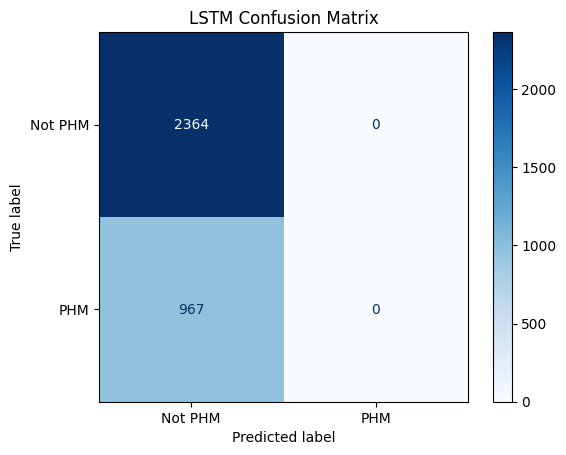


Bi-LSTM Evaluation:
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8065 - loss: 0.4238
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2364
           1       0.75      0.63      0.69       967

    accuracy                           0.83      3331
   macro avg       0.81      0.77      0.79      3331
weighted avg       0.83      0.83      0.83      3331


Test Accuracy: 0.8334
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2364
           1       0.75      0.63      0.69       967

    accuracy                           0.83      3331
   macro avg       0.81      0.77      0.79      3331
weighted avg       0.83      0.83      0.83      3331



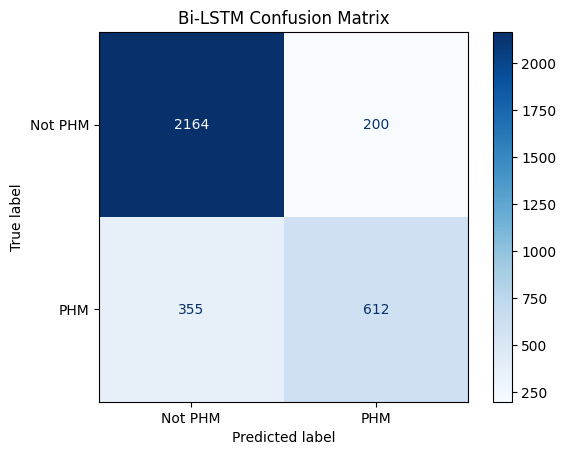

In [18]:
from sklearn.metrics import classification_report
def evaluate_model(model, model_name, X_test, y_test):
    print(f"\n{model_name} Evaluation:")
    loss, accuracy = model.evaluate(X_test, y_test)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=['Not PHM', 'PHM'],
        cmap='Blues'
    )
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

evaluate_model(lstm_model, "LSTM", X_test, y_test)
evaluate_model(bilstm_model, "Bi-LSTM", X_test, y_test)

Visualize Training

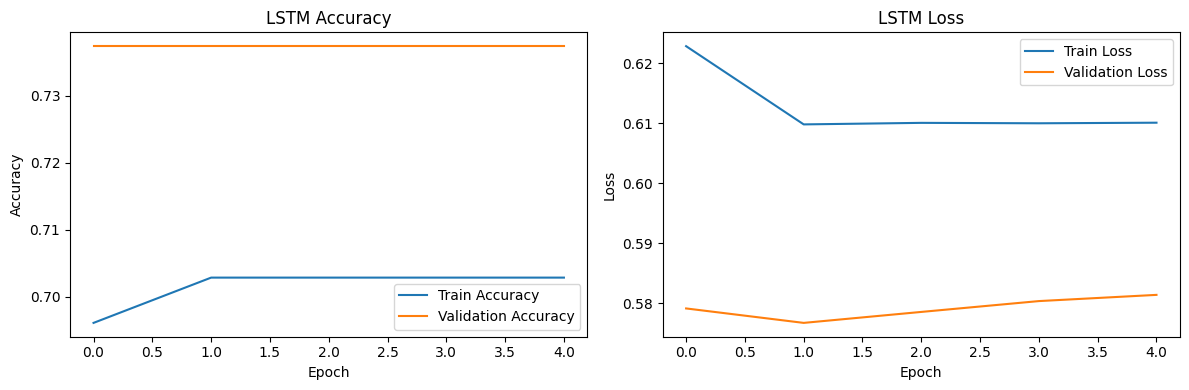

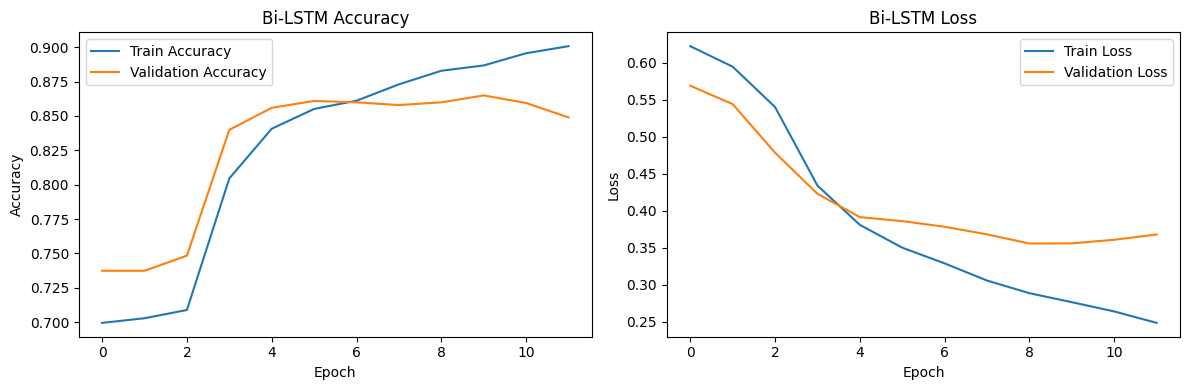

In [19]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(lstm_history, "LSTM")
plot_history(bilstm_history, "Bi-LSTM")

In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    # Remove URLs, mentions, hashtags
    tweet = re.sub(r'http\S+|@\w+|#\w+', '', tweet)
    # Remove special characters except letters and numbers
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    # Lemmatization (optional but recommended)
    tweet = ' '.join([lemmatizer.lemmatize(word) for word in tweet.split()])
    return tweet.lower().strip()

# Apply cleaning to both datasets
train_df['cleaned_tweet'] = train_df['tweet'].apply(clean_tweet)
test_df['cleaned_tweet'] = test_df['tweet'].apply(clean_tweet)